In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
METRIC = "systemic_failure"

In [3]:
df = pd.read_csv("../acs_results.csv")
CONFORMAL = False
N_TRAIN = 2588885
MIN_DATA_SCALE = int(N_TRAIN/10)
PARTITIONS_DATA_SCALE = MIN_DATA_SCALE
df["data_scale"] = (N_TRAIN/df["data_scale"]).astype(int)

In [4]:
df = df.drop(columns=["random_seed", "task_type"])
df = df.groupby(["exp_type", "random_distance", "num_models", "data_scale", "method"]).mean().reset_index(drop=False)

In [5]:
def table_by_models(data, metric, exp_type="baseline", method="lockout", data_scale=MIN_DATA_SCALE):
    df = data
    df = df[df["data_scale"]==MIN_DATA_SCALE]
    df = df[df["method"]==method]
    df = df[df["exp_type"]==exp_type]
    df = df[["num_models", "random_distance", metric]]
    df = df[df["num_models"]>1]
    rows = []
    for r in df["random_distance"].unique():
        row = {}
        row["random_distance"] = r
        for n in np.sort(df["num_models"].unique()):
            row[str(n)] = float(df.loc[(df["random_distance"]==r) & (df["num_models"]==n), metric])
        rows.append(row)
    return pd.DataFrame(rows).round(3)

In [6]:
def table_by_data(data, metric, exp_type="baseline", method="lockout", num_models=2):
    df = data
    df = df[df["num_models"]==num_models]
    df = df[df["method"]==method]
    df = df[df["exp_type"]==exp_type]
    df = df[["data_scale", "random_distance", metric]]
    rows = []
    for r in df["random_distance"].unique():
        row = {}
        row["random_distance"] = r
        for n in np.sort(df["data_scale"].unique()):
            row[str(n)] = float(df.loc[(df["random_distance"]==r) & (df["data_scale"]==n), metric])
        rows.append(row)
    return pd.DataFrame(rows).round(3)

In [7]:
def table_by_fairness(data, metrics):
    df = data
    df = df[df["method"]=="lockout"]
    df = df[df["exp_type"]=="baseline"]
    df = df[df["num_models"]==10]
    df = df[df["data_scale"]==MIN_DATA_SCALE]
    
    cols = ["random_distance"]
    for m in metrics:
        cols.append(m+"_0")
        cols.append(m+"_1")
    return df[cols].reset_index(drop=True).round(3)

In [8]:
def plot(data, metric, xaxis, exp_type="baseline", method="lockout", ylog=False, ylim=None, save=False):
    plt.rcParams["figure.figsize"] = [7,3]
    fig, ax = plt.subplots()

    df = data
    df = df[df["method"]==method]
    df = df[df["exp_type"]==exp_type]
    df = df[df[xaxis]>1]

    if CONFORMAL:
        plt.plot(df.loc[df["random_distance"]==0, xaxis], df.loc[df["random_distance"]==0, metric], '*-', color='green', label="Threshold")
        plt.plot(df.loc[df["random_distance"]==0.05, xaxis], df.loc[df["random_distance"]==0.05, metric], '*-', color='#001e49', label="Alpha = 0.05")
        plt.plot(df.loc[df["random_distance"]==0.1, xaxis], df.loc[df["random_distance"]==0.1, metric], '*-', color='#002f70', label="Alpha = 0.1")
        plt.plot(df.loc[df["random_distance"]==0.2, xaxis], df.loc[df["random_distance"]==0.2, metric], '*-', color='#003f97', label="Alpha = 0.2")
        plt.plot(df.loc[df["random_distance"]==0.3, xaxis], df.loc[df["random_distance"]==0.3, metric], '*-', color='#004fbf', label="Alpha = 0.3")
        plt.plot(df.loc[df["random_distance"]==0.4, xaxis], df.loc[df["random_distance"]==0.4, metric], '*-', color='#0068f9', label="Alpha = 0.4")
    else:
        plt.plot(df.loc[df["random_distance"]==0, xaxis], df.loc[df["random_distance"]==0, metric], '*-', color='green', label="Threshold")
        plt.plot(df.loc[df["random_distance"]==0.1, xaxis], df.loc[df["random_distance"]==0.1, metric], '*-', color='#001e49', label="Random(0.4,0.6)")
        plt.plot(df.loc[df["random_distance"]==0.2, xaxis], df.loc[df["random_distance"]==0.2, metric], '*-', color='#002f70', label="Random(0.3,0.7)")
        plt.plot(df.loc[df["random_distance"]==0.3, xaxis], df.loc[df["random_distance"]==0.3, metric], '*-', color='#003f97', label="Random(0.2,0.8)")
        plt.plot(df.loc[df["random_distance"]==0.4, xaxis], df.loc[df["random_distance"]==0.4, metric], '*-', color='#004fbf', label="Random(0.1,0.9)")
        plt.plot(df.loc[df["random_distance"]==0.5, xaxis], df.loc[df["random_distance"]==0.5, metric], '*-', color='#0068f9', label="All Random")


    if ylim:
        plt.ylim(ylim)
    if ylog:
        plt.yscale('log')   

    plt.xlabel(xaxis)
    plt.ylabel(metric)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    fig.tight_layout()
    plt.show()

In [9]:
def plot_fairness(data, metrics=[],labels=[], exp_type="baseline", method="lockout"):
    plt.rcParams["figure.figsize"] = [5.5,3]
    fig, ax = plt.subplots()

    df = data
    df = df[df["method"]==method]
    df = df[df["exp_type"]==exp_type]
    df = df[df["num_models"]==10]
    df = df[df["data_scale"]==MIN_DATA_SCALE]
    
    metric_lines = []
    class_lines = []
    colors = ["blue", "green", "red"]
    for i,m in enumerate(metrics):
        lin1, = plt.plot(df["random_distance"], df[m+"_0"], '*--', color=colors[i])
        lin2, = plt.plot(df["random_distance"], df[m+"_1"], '*-', color=colors[i])
        if i==0:
            class_lines.append(lin1)
            class_lines.append(lin2)
        metric_lines.append(lin2)
    
    if CONFORMAL:
        plt.xlabel("Significance Level (alpha) for Randomized Prediction")
    else:
        plt.xlabel("Distance from Threshold for Randomized Predictions")
        
    legend1 = plt.legend(class_lines, ["Minority Class", "Majority Class"], bbox_to_anchor=(1.05, 0.25), loc='upper left')
    plt.legend(metric_lines, labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.gca().add_artist(legend1)

In [10]:
def plot_tasks(data, metric, method="lockout", num_tasks=2):
    plt.rcParams["figure.figsize"] = [5,3]
    fig, ax = plt.subplots()

    df = data
    df = df[df["method"]==method]
    df = df[df["exp_type"]=="tasks"]
    df = df[df["data_scale"]==MIN_DATA_SCALE]
    df = df[df["num_models"]==num_tasks]

    plt.bar(np.array(df["random_distance"]), np.array(df[metric]), width=0.02)

    if CONFORMAL:
        plt.xlabel("Significance Level (alpha) for Randomized Prediction")
    else:
        plt.xlabel("Distance from Threshold for Randomized Predictions")
        
    plt.ylabel(metric)
    
    fig.tight_layout()
    plt.show()

# Results -- Accuracy

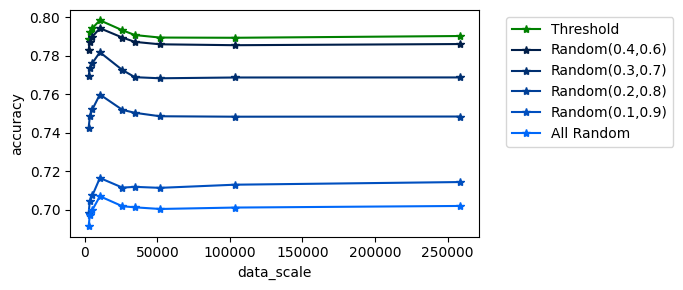

In [11]:
plot(df[df["num_models"]==10], "accuracy", "data_scale")

In [12]:
table_by_models(df, "accuracy")[["random_distance", "10"]].rename(columns={'10':"accuracy"})

,random_distance,accuracy
0,0.0,0.790
1,0.1,0.786
2,0.2,0.769
3,0.3,0.748
4,0.4,0.714
5,0.5,0.702


### Acceptance Rate 

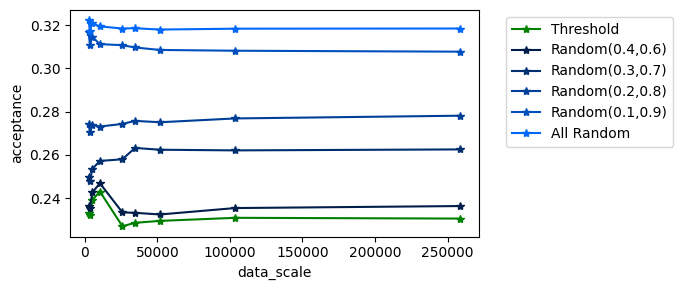

In [13]:
plot(df[df["num_models"]==10], "acceptance", "data_scale")

# Results -- Homogenization As Repeated Inaccurate Decisions

### Baseline: Homogenization Across Same Model Class + Training Data + Prediction Task

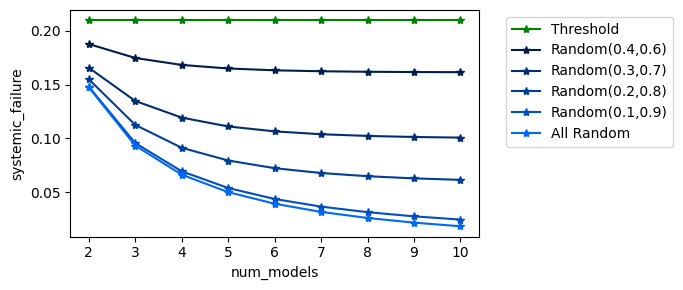

In [14]:
plot(df[df["data_scale"]==MIN_DATA_SCALE], METRIC, "num_models", "baseline", "inaccurate")

In [15]:
table_by_models(df, METRIC, "baseline", "inaccurate")

,random_distance,2,3,4,5,6,7,8,9,10
0,0.0,0.210,0.210,0.210,0.210,0.210,0.210,0.210,0.210,0.210
1,0.1,0.188,0.175,0.168,0.165,0.163,0.162,0.162,0.162,0.162
2,0.2,0.166,0.135,0.119,0.111,0.106,0.104,0.102,0.101,0.101
3,0.3,0.155,0.113,0.091,0.079,0.072,0.068,0.065,0.063,0.061
4,0.4,0.148,0.096,0.069,0.054,0.044,0.037,0.031,0.027,0.024
5,0.5,0.148,0.093,0.066,0.050,0.039,0.032,0.026,0.022,0.018


### Different Training Data (Same Model Class + Prediction Task)

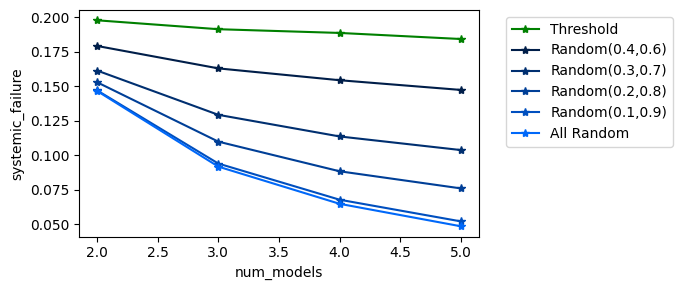

In [16]:
plot(df[df["data_scale"]==PARTITIONS_DATA_SCALE], METRIC, "num_models", "data_partitions", "inaccurate")

### Different Model Classes (Same Training Data + Prediction Task)

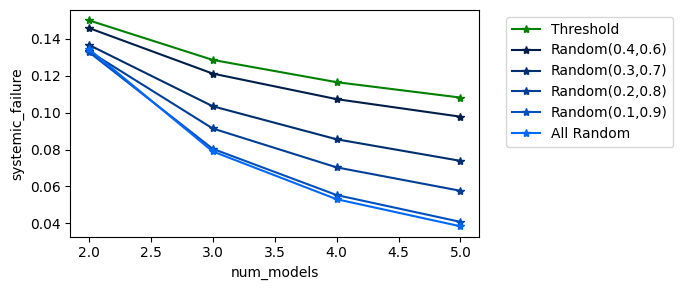

In [17]:
plot(df[df["data_scale"]==MIN_DATA_SCALE], METRIC, "num_models", "models", "inaccurate")

### Different Prediction Tasks (Same Model Class + Training Data)

In [18]:
table_by_models(df, METRIC, "tasks", "inaccurate").rename(columns={'2': METRIC})

,random_distance,systemic_failure,3
0,0.0,0.048,0.011
1,0.1,0.049,0.011
2,0.2,0.057,0.014
3,0.3,0.066,0.017
4,0.4,0.085,0.026
5,0.5,0.091,0.029


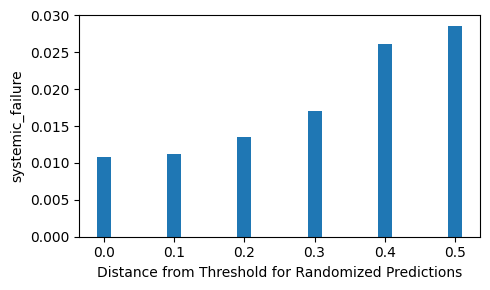

In [19]:
plot_tasks(df, METRIC, "inaccurate", 3)

# Results -- Homogenization As Repeated Negative Decisions

### Baseline: Homogenization Across Same Model Class + Training Data + Prediction Task

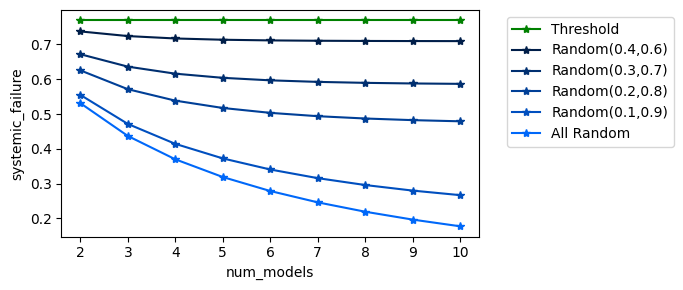

In [20]:
plot(df[df["data_scale"]==MIN_DATA_SCALE], METRIC, "num_models", "baseline", "lockout")

In [21]:
table_by_models(df, METRIC, "baseline", "lockout")

,random_distance,2,3,4,5,6,7,8,9,10
0,0.0,0.769,0.769,0.769,0.769,0.769,0.769,0.769,0.769,0.769
1,0.1,0.737,0.724,0.717,0.714,0.712,0.711,0.710,0.710,0.710
2,0.2,0.672,0.636,0.616,0.604,0.597,0.592,0.590,0.588,0.587
3,0.3,0.625,0.571,0.538,0.517,0.503,0.494,0.487,0.482,0.479
4,0.4,0.555,0.471,0.414,0.372,0.340,0.316,0.296,0.280,0.267
5,0.5,0.531,0.437,0.370,0.319,0.279,0.246,0.219,0.196,0.177


### Different Training Data (Same Model Class + Prediction Task)

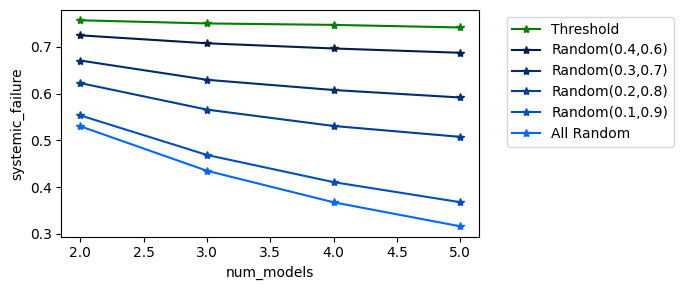

In [22]:
plot(df[df["data_scale"]==PARTITIONS_DATA_SCALE], METRIC, "num_models", "data_partitions", "lockout")

### Different Model Classes (Same Training Data + Prediction Task)

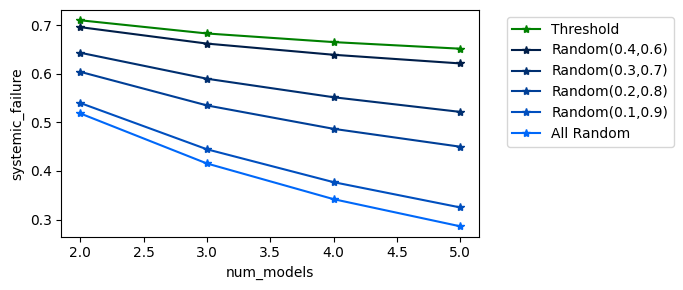

In [23]:
plot(df[df["data_scale"]==MIN_DATA_SCALE], METRIC, "num_models", "models", "lockout")

### Different Prediction Tasks (Same Model Class + Training Data)

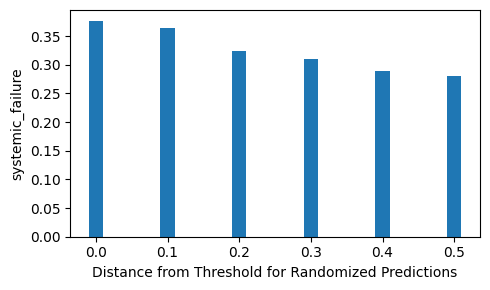

In [24]:
plot_tasks(df, METRIC, "lockout", 3)

# Results -- By Data Scale

### Homogenization As Repeated Inaccurate Decisions

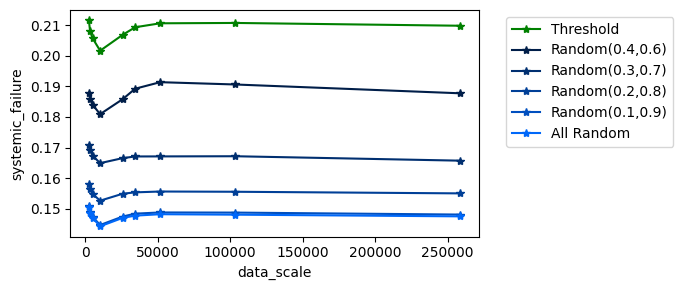

In [25]:
plot(df[df["num_models"]==2], METRIC, "data_scale", "baseline", "inaccurate")

### Homogenization As Repeated Negative Decisions

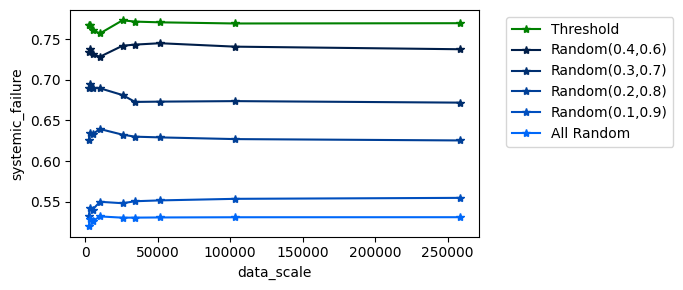

In [26]:
plot(df[df["num_models"]==2], METRIC, "data_scale", "baseline", "lockout")